Computer Exersize 1

In [4]:
# Loading data and importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.linalg import svd, norm
import cv2

# Assuming compEx1data.mat has a variable x that is a cell array 
# with x[0] and x[1] storing matched points.
data = loadmat('compEx1data.mat')
x = data['x']  # This is typically a 1x2 cell array in MATLAB


x1 = x[0,0]  # first set of points, shape is 3×N
x2 = x[1,0]  # second set of points, shape is 3×N

# Check sizes
print("x1 shape:", x1.shape)
print("x2 shape:", x2.shape)


x1 shape: (3, 2008)
x2 shape: (3, 2008)


In [5]:
# Normalization of Points
VERIFY_POINTS_ARE_NORMALIZED = False

def normalize_2D_points(x):
    """
    x: 3 x N array of homogeneous 2D points [x; y; 1].
       If x is shape (3, N), each column is a point.
    Returns:
        x_norm: 3 x N array of normalized points
        N:      3 x 3 normalization matrix
    """
    # Convert to Cartesian coordinates, ignoring the last row if it is not 1
    x_cart = x[:2, :] / x[2, :]
    
    # 1) Compute mean
    mean_x = np.mean(x_cart[0, :])
    mean_y = np.mean(x_cart[1, :])
    
    # 2) Compute std in each coordinate
    std_x = np.std(x_cart[0, :])
    std_y = np.std(x_cart[1, :])
    
    # Build the normalization matrix N
    # We'll shift by the mean, then scale by 1/std
    # N = [[1/std_x, 0,       -mean_x/std_x ],
    #      [0,       1/std_y, -mean_y/std_y ],
    #      [0,       0,       1           ]]
    N = np.array([[1/std_x, 0,       -mean_x/std_x],
                  [0,       1/std_y, -mean_y/std_y],
                  [0,       0,        1           ]], dtype=float)
    
    # Apply N to x (in homogeneous form)
    x_norm = N @ x
    
    return x_norm, N

# Normalize the 2D points for each image
x1n, N1 = normalize_2D_points(x1)
x2n, N2 = normalize_2D_points(x2)

if VERIFY_POINTS_ARE_NORMALIZED:
    # Check that the points are normalized
    #print("N1 @ x1 =\n", N1 @ x1)
    #print("N2 @ x2 =\n", N2 @ x2)

    # Check that the points are normalized
    #print("N1 @ x1n =\n", N1 @ x1n)
    #print("N2 @ x2n =\n", N2 @ x2n)
    # Create a subplot with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot normalized points for image 1
    axs[0].scatter(x1n[0, :], x1n[1, :], c='r', label='Image 1 normalized')
    axs[0].axis('equal')
    axs[0].set_title('Normalized points for image 1')
    axs[0].legend()

    # Plot normalized points for image 2
    axs[1].scatter(x2n[0, :], x2n[1, :], c='b', label='Image 2 normalized')
    axs[1].axis('equal')
    axs[1].set_title('Normalized points for image 2')
    axs[1].legend()

    # Show the plots
    plt.show()

In [6]:
# Set up M
def build_M_matrix(x1n, x2n):
    """
    x1n, x2n: 3xN arrays of corresponding points in normalized coords.
    Returns:
        M: Nx9 array for the eight-point algorithm
    """
    # Number of points:
    N = x1n.shape[1]
    M = np.zeros((N, 9))
    
    for i in range(N):
        # Outer product:
        xx = np.outer(x2n[:, i], x1n[:, i])  # 3x3
        # Flatten and place as a row in M:
        M[i, :] = xx.flatten()
    
    return M

M = build_M_matrix(x1n, x2n)
print("M shape:", M.shape)

# Solve "Minimize||Mv|| subject to ||v||=1"
U_M, S_M, Vt_M = svd(M)   # M = U_M * diag(S_M) * Vt_M
v = Vt_M[-1, :]          # The last row of V^T is the singular vector for smallest singular value
# Or we can do v = Vt_M.T[:, -1]
print("Smallest singular value of M:", S_M[-1])
print("Vector v shape:", v.shape)
F_tilde_approx = v.reshape(3,3)
residual = np.dot(M, v)
print("|| Mv || =", norm(residual))


M shape: (2008, 9)
Smallest singular value of M: 0.049654500195107414
Vector v shape: (9,)
|| Mv || = 0.049654500195106914


In [7]:
# Enforce det(F_tilde) = 0
Uf, Sf, Vtf = svd(F_tilde_approx)
# Enforce rank-2
Sf[-1] = 0
F_tilde = Uf @ np.diag(Sf) @ Vtf

# Now F_tilde has det=0
print("det(F_tilde) after rank-2 enforcement:", np.linalg.det(F_tilde))

# For each correspondence, x2n[:, i].T @ F_tilde @ x1n[:, i] should be close to zero
errors = []
for i in range(x1n.shape[1]):
    val = x2n[:, i].T @ F_tilde @ x1n[:, i]
    errors.append(val)

errors = np.array(errors)
print("Checking x2n.T @ F_tilde @ x1n = 0 is roughly fullfilled with \nmean epipolar constraint in normalized coords:", np.mean(np.abs(errors)))


det(F_tilde) after rank-2 enforcement: 1.0802635241810483e-18
Checking x2n.T @ F_tilde @ x1n = 0 is roughly fullfilled with 
mean epipolar constraint in normalized coords: 0.000715898132975785


In [8]:
# F = N2.T @ F_tilde @ N1, our formula from Exercise 3
F_unnormalized = N2.T @ F_tilde @ N1

# Rescale F so that F(3,3) = 1
f33 = F_unnormalized[2,2]
if np.abs(f33) < 1e-12:
    print("Warning: F(3,3) is near zero, cannot safely rescale.")
else:
    F_unnormalized /= f33
print(f'Check F(3,3) = 1 \n {F_unnormalized}')




Check F(3,3) = 1 
 [[-3.3901069316072084e-08, -3.7200533844642334e-06, 0.005772312832305452], [4.667369031726206e-06, 2.893608325990422e-07, -0.026682103359356633], [-0.007193603737897985, 0.026295710857867208, 1.0]]


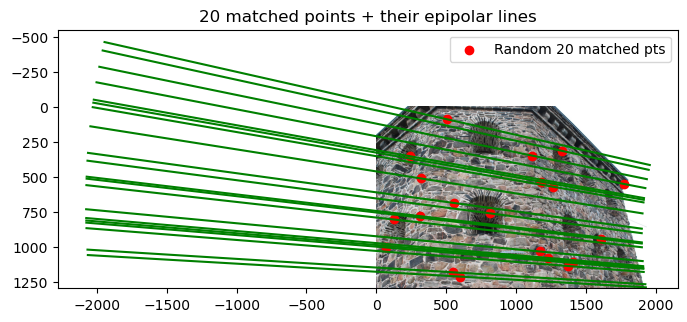

In [14]:
from rital import rital

# Load the second image
img2 = cv2.imread("kronan2.jpg")  # Load as BGR (default)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display in Matplotlib

# 1. Randomly select 20 indices
N = x1.shape[1]
rand_indices = np.random.choice(N, 20, replace=False)

# 2. Extract inhomogeneous coordinates of x2
x2_inhom = x2[:2, :] / x2[2, :]

# 3. Compute epipolar lines for the selected points in the second image
epipolar_lines = F_unnormalized @ x1[:, rand_indices]  # Shape (3, 20)

# 4. Plot the second image
plt.figure(figsize=(8, 8))
plt.imshow(img2, cmap='gray')  # Display the image as background
plt.scatter(x2_inhom[0, rand_indices], x2_inhom[1, rand_indices], 
            c='r', marker='o', label='Random 20 matched pts')

plt.title("20 matched points + their epipolar lines")
plt.legend()

# 5. Use rital to draw epipolar lines on the image
rital(epipolar_lines, st='g-', SCALAR=2000)  # Draw green epipolar lines

plt.show()


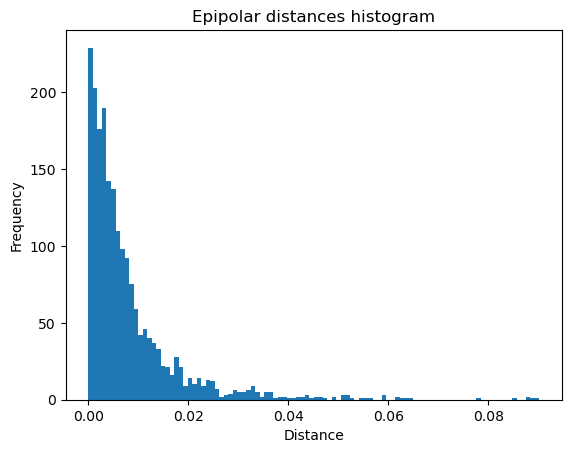

Mean epipolar distance : 0.008124251966516019


In [29]:
# Compute distances
lines = F_unnormalized @ x1  # 3xN lines in second image
# Normalize line so sqrt(a^2 + b^2) = 1 => simpler distance formula
a = lines[0,:]
b = lines[1,:]
c = lines[2,:]

# Distances:
x2_inhom = x2[:2,:]/x2[2,:]
distances = np.abs(a*x2_inhom[0,:] + b*x2_inhom[1,:] + c)
mean_dist = np.mean(distances)

plt.figure()
plt.hist(distances, bins=100)
plt.title("Epipolar distances histogram")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

print("Mean epipolar distance :", mean_dist)


Check F normalized(3,3) = 1 
 [[ 1.53141873e-01  1.33178455e+01 -3.50453807e+01]
 [-1.60753241e+01 -7.89826286e-01  1.84565958e+02]
 [ 4.09850402e+01 -1.86547181e+02  1.00000000e+00]]


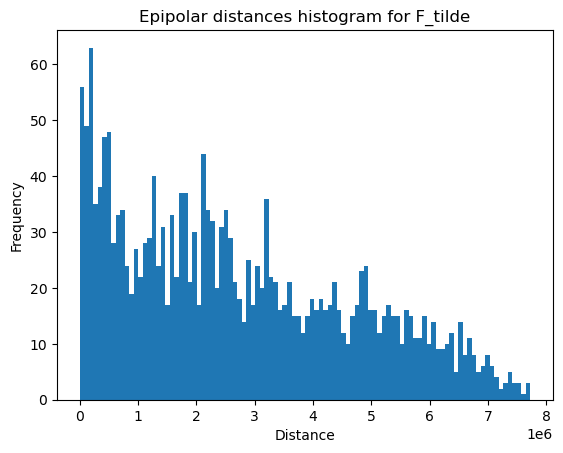

Mean epipolar distance for F_tilde : 2712350.6169396974


In [9]:
# REDO but with N_1 = N_2 = I


# F = N2.T @ F_tilde @ N1, our formula from Exercise 3
# Enforce det(F_tilde) = 0
Uf, Sf, Vtf = svd(F_tilde_approx)
# Enforce rank-2
Sf[-1] = 0
F_tilde = Uf @ np.diag(Sf) @ Vtf

# Rescale F so that F(3,3) = 1
f33 = F_tilde[2,2]
if np.abs(f33) < 1e-12:
    print("Warning: F(3,3) is near zero, cannot safely rescale.")
else:
    F_tilde /= f33
print(f'Check F normalized(3,3) = 1 \n {F_tilde}')
# Compute distances
lines = F_tilde @ x1  # 3xN lines in second image
# Normalize line so sqrt(a^2 + b^2) = 1 => simpler distance formula
a = lines[0,:]
b = lines[1,:]
c = lines[2,:]

# Distances:
x2_inhom = x2[:2,:]/x2[2,:]
distances = np.abs(a*x2_inhom[0,:] + b*x2_inhom[1,:] + c)
mean_dist = np.mean(distances)

plt.figure()
plt.hist(distances, bins=100)
plt.title("Epipolar distances histogram for F_tilde")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

print("Mean epipolar distance for F_tilde :", mean_dist)